In [34]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline
from torch import optim
import os
import numpy as np
import time
import itertools

from PIL import Image
from copy import deepcopy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
data_path = './GANdata'
os.makedirs(data_path, exist_ok=True)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_ds = datasets.MNIST(data_path, train=True, transform=transform, download=True)

In [7]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [8]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

#for check

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [35]:
# Some blocks

class ResBlock2d(nn.Module):
    def __init__(self, channels, kernel_size, stride, use_dropout, use_bias, padding):
        super(ResBlock2d, self).__init__()
        self.conv_block = []
        self.conv_block.append(nn.Conv2d(channels, channels, kernel_size, stride, bias=use_bias, padding=padding))
        if use_dropout > 0:
            self.conv_block.append(nn.Dropout(use_dropout))
        self.conv_block.append(nn.Conv2d(channels, channels, kernel_size, stride, bias=use_bias, padding=padding))
        
        self.conv_block = nn.Sequential(*self.conv_block)
        
        
    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class ResNorm2d(nn.Module):
    def __init__(self, channels, kernel_size, stride, use_dropout=0, padding=0, use_bias=False, norm_type=nn.InstanceNorm2d, activation_type=nn.ReLU, activation_value=True):
        super(ResNorm2d, self).__init__()
        self.res = ResBlock2d(channels, kernel_size, stride, use_dropout, use_bias, padding)
        self.norm = norm_type(channels)
        if activation_type != nn.ReLU:
            self.activation = activation_type(activation_value, inplace=True)
        else:
            self.activation = activation_type(activation_value)
        
        self.model = nn.Sequential(self.res, self.norm, self.activation)
        
    
    def forward(self, x):
        #print(x.shape)
        return self.model(x)
        

class ConvNorm2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0, use_dropout=0, use_bias=False, norm_type=nn.InstanceNorm2d, activation_type=nn.ReLU, activation_value=True):
        super(ConvNorm2d, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias=use_bias, padding=padding)
        self.norm = norm_type(out_channels)
        if activation_type != nn.ReLU:
            self.activation = activation_type(activation_value, inplace=True)
        else:
            self.activation = activation_type(activation_value)
        
        self.model = nn.Sequential(self.conv2d, self.norm, self.activation)
        
    
    def forward(self, x):
        #print(x.shape)
        return self.model(x)
    

class UpConvNorm2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0, output_padding=0, use_dropout=0, use_bias=False, norm_type=nn.InstanceNorm2d, activation_type=nn.ReLU, activation_value=True):
        super(UpConvNorm2d, self).__init__()
        self.upconv2d = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, bias=use_bias, padding=padding, output_padding=output_padding)
        self.norm = norm_type(out_channels)
        if activation_type != nn.ReLU:
            self.activation = activation_type(activation_value, inplace=True)
        else:
            self.activation = activation_type(activation_value)
        
        self.model = nn.Sequential(self.upconv2d, self.norm, self.activation)

    
    def forward(self, x):
        #print(x.shape)
        return self.model(x)
        

In [94]:
# Generator

class Generator(nn.Module):
    def __init__(self, ngf, nc, img_size=(3, 128, 128), norm_type=nn.InstanceNorm2d, use_dropout=0):
        super(Generator, self).__init__()
        self.img_size = img_size # 1 x 28 x 28 for MNIST
        self.ngf = ngf
        self.nc = nc
        self.use_bias = (norm_type == nn.InstanceNorm2d)
        self.norm_type = norm_type
        
        if img_size[-1] == 128:
            self.get_resnet(in_channels=self.img_size[0], down=2, mid=6, use_dropout=use_dropout)
        elif img_size[-1] == 256:
            self.get_resnet(in_channels=self.img_size[0], down=2, mid=9, use_dropout=use_dropout)
        else:
            raise AttributeError
        

    def get_resnet(self, in_channels, down, mid, use_dropout):
        self.model = []
        out_channels = self.ngf
        self.model.append(nn.ReflectionPad2d(3)) # paper
        self.model.append(ConvNorm2d(in_channels, out_channels, 7, 1, padding=0, use_dropout=use_dropout, use_bias=self.use_bias, norm_type=self.norm_type))
        # downsampling
        for i in range(1, down+1):
            self.model.append(ConvNorm2d(out_channels, out_channels*2, 3, 2, padding=1, use_dropout=use_dropout, use_bias=self.use_bias, norm_type=self.norm_type))
            out_channels *= 2
        
        # res
        for i in range(1, mid+1):
            self.model.append(ResNorm2d(out_channels, 3, 1, use_dropout=use_dropout, use_bias=self.use_bias, norm_type=self.norm_type, padding=1))
        # TODO - add reflection padding at ResNorm2d
        # upsampling
        for i in range(1, down+1):
            self.model.append(UpConvNorm2d(out_channels, out_channels//2, 3, 2, padding=1, output_padding=1, use_dropout=use_dropout, use_bias=self.use_bias, norm_type=self.norm_type))
            out_channels //= 2
        
        self.model.append(nn.ReflectionPad2d(3)) # paper
        self.model.append(nn.Conv2d(out_channels, self.nc, 7, 1, bias=self.use_bias, padding=0))
        self.model.append(nn.Tanh())
        
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [4]:
with torch.no_grad():
    # test generator_resnet
    test_generator = Generator(64, 3, (3, 128, 128)).to(device)
    test_noise = torch.randn(1, 3, 128, 128).to(device)
    output = test_generator(test_noise)
    print(output.shape)

torch.Size([1, 3, 134, 134])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
torch.Size([1, 3, 128, 128])


In [37]:
class Discriminator(nn.Module):
    def __init__(self, ngf, nc, img_size=(3, 128, 128), norm_type=nn.InstanceNorm2d, use_dropout=0):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.ngf = ngf
        self.nc = nc
        self.use_bias = (norm_type == nn.InstanceNorm2d)
        self.norm_type = norm_type
        
        self.get_model(img_size[0], 4, use_dropout)
        
    
    def get_model(self, in_channels, n, use_dropout):
        self.model = []
        # self.model.append(nn.Conv2d(in_channels, self.ngf, 4, 2, padding=1))
        # self.model.append(nn.LeakyReLU(0.2, True))
        #in_channels = self.ngf
        out_channels = self.ngf
        for _ in range(n-1):
            self.model.append(ConvNorm2d(in_channels, out_channels, 4, 2, use_bias=self.use_bias, padding=1, norm_type=self.norm_type, activation_type=nn.LeakyReLU, activation_value=0.2))
            in_channels = out_channels
            out_channels *= 2
        
        self.model.append(ConvNorm2d(in_channels, in_channels, 4, 1, use_bias=self.use_bias, padding=1, norm_type=self.norm_type, activation_type=nn.LeakyReLU, activation_value=0.2))
        
        self.model.append(nn.Conv2d(in_channels, 1, 4, 1, padding=1))
        self.model = nn.Sequential(*self.model)
    
    def forward(self, img):
        output = self.model(img)
        return output

In [31]:
with torch.no_grad():
    # test discriminator
    test_discriminator = Discriminator(64, 3, (3, 128, 128)).to(device)
    test_noise = torch.randn(1, 3, 128, 128).to(device)
    output = test_discriminator(test_noise)
    print(output.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 14, 14])


In [76]:
class CycleGANCustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, mode='train', res=128, serial_batches=False):
        super(CycleGANCustomDataset, self).__init__()
        self.path_A = dataset_path + "/" + mode + "A/"
        self.path_B = dataset_path + "/" + mode + "B/"
        
        self.img_list_A = sorted(os.listdir(self.path_A))
        self.img_list_B = sorted(os.listdir(self.path_B))
        
        self.len_A = len(self.img_list_A)
        self.len_B = len(self.img_list_B)
        self.res = res
        self.serial_batches = serial_batches
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                          transforms.Resize(res, transforms.InterpolationMode.BICUBIC),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])
    def __len__(self):
        return max(self.len_A, self.len_B)
    
    
    def __getitem__(self, index):
        img_A = self.transform(Image.open(self.path_A+self.img_list_A[index % self.len_A]).convert('RGB'))
        if self.serial_batches:
            index_b = index % self.len_B
        else:
            index_b = int(torch.randint(0, self.len_B - 1, (1,))[0])
        img_B = self.transform(Image.open(self.path_B+self.img_list_B[index_b]).convert('RGB'))
        #print(img_A, img_B)
        return {'A': img_A, 'B': img_B}

In [97]:
class CycleGAN():
    
    def __init__(self, generator, discriminator, ngf, ndf, nc, img_size, device, lambda_cyc=10, lambda_id=0.5, gan_loss_type=nn.MSELoss):
        
        self.ngf = ngf
        self.ndf = ndf
        self.nc = nc
        self.img_size = img_size
        self.lambda_cyc = lambda_cyc
        self.lambda_id = lambda_id
        self.G_A = generator(ngf, nc, img_size, use_dropout = 0.5).to(device)
        self.G_B = generator(ngf, nc, img_size, use_dropout = 0.5).to(device)
        self.D_A = discriminator(ndf, nc, img_size).to(device)
        self.D_B = discriminator(ndf, nc, img_size).to(device)
        self.gan_loss_type = gan_loss_type
        
        self.initialize_network(init_type='normal', init_gain=0.02)
    
    def loss_GAN(self, prediction, target):
        return self.gan_loss_type()(prediction, target)
    
    def loss_cycle(self, f_g_x, x, g_f_y, y):
        return nn.L1Loss()(f_g_x, x) + nn.L1Loss()(g_f_y, y)
    
    def loss_id(self, g_y, y, f_x, x):
        return nn.L1Loss()(g_y, y) + nn.L1Loss()(f_x, x)
    
    def set_optimizer(self, lr, beta1):
        self.opt_G = optim.Adam(itertools.chain(self.G_A.parameters(), self.G_B.parameters()), lr=lr, betas=(beta1, 0.999))
        self.opt_D = optim.Adam(itertools.chain(self.D_A.parameters(), self.D_B.parameters()), lr=lr, betas=(beta1, 0.999))
    
    
    def get_scheduler(self, optimizer, num_epochs, lr_args):
        lr_policy = lr_args['lr_policy']
        if lr_policy == 'linear':
            def lambda_rule(epoch):
                lr_l = 1.0 - max(0, epoch + lr_args['epoch_count'] - num_epochs) / float(lr_args['n_epochs_decay'] + 1) # start epoch는 1로?
                return lr_l
            scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
        elif lr_policy == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_args['lr_decay_iters'], gamma=0.1)
        elif lr_policy == 'plateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
        elif lr_policy == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        else:
            return NotImplementedError('learning rate policy [%s] is not implemented', lr_args['lr_policy'])

        return scheduler
    
    def initialize_network(self, init_type='normal', init_gain=0.02):
        
        def initialize_model(model):
            classname = model.__class__.__name__
            
            if hasattr(model, 'weight') and classname.find('Conv') != -1 or classname.find('Linear') != -1:
                if init_type == 'normal':
                    nn.init.normal_(model.weight.data, 0.0, init_gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(model.weight.data, gain=init_gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(model.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(model.weight.data, gain=init_gain)
                else:
                    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
                if hasattr(model, 'bias') and model.bias is not None:
                    nn.init.constant_(model.bias.data, 0)
            # batchnorm
            elif classname.find('BatchNorm') != -1: # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
                nn.init.normal_(model.weight.data, 1.0, gain=init_gain)
                nn.init.constant_(model.bias.data, 0)
        
        self.D_A.apply(initialize_model)
        self.D_B.apply(initialize_model)
        self.G_A.apply(initialize_model)
        self.G_B.apply(initialize_model)
    
    
    def train(self, dataloader, num_epochs, lr_args):
        # log 관련
        log_dict = {'loss_G': [], 'loss_D': []}
        cnt = 0
        
        self.set_optimizer(lr_args['lr'], 0.5)
        scheduler_D = self.get_scheduler(self.opt_D, num_epochs, lr_args)
        scheduler_G = self.get_scheduler(self.opt_G, num_epochs, lr_args)
        for epoch in range(num_epochs):
            for i, data in enumerate(dataloader):
                # TODO : dataloader에 collate 작성해서 A, B를 따로 빼 올 수 있도록 하기
                #print(i, data)
                x_batch_A = data['A'].to(device)
                x_batch_B = data['B'].to(device)

                # G
                self.opt_G.zero_grad()
                for param in self.D_A.parameters():
                    param.requires_grad=False
                for param in self.D_B.parameters():
                    param.requires_grad=False

                G_A_output = self.G_A(x_batch_A) # fake B
                D_B_G_A_output = self.D_B(G_A_output) # discriminate fake B
                B_G_A_output = self.G_B(G_A_output) # reconstructed A
                G_B_output = self.G_B(x_batch_B) # fake A
                D_A_G_B_output = self.D_A(G_B_output) # discriminate fake A
                A_G_B_output = self.G_A(G_B_output) # reconstructed B
                
                real_y = torch.ones_like(D_B_G_A_output).to(device)
                fake_y = torch.ones_like(D_B_G_A_output).to(device)
                
                g1 = self.loss_GAN(D_B_G_A_output, real_y.detach())
                g2 = self.loss_GAN(D_A_G_B_output, real_y.detach())
                loss_GAN = g1 + g2
                loss_cycle = self.lambda_cyc * self.loss_cycle(B_G_A_output, x_batch_A, A_G_B_output, x_batch_B)
                loss_id = self.lambda_id * self.loss_id(G_A_output, x_batch_A, G_B_output, x_batch_B)
                loss_G = loss_GAN + loss_cycle + loss_id
                
                loss_G.backward()
                self.opt_G.step()
                
                # D
                for param in self.D_A.parameters():
                    param.requires_grad=True
                for param in self.D_B.parameters():
                    param.requires_grad=True
                self.opt_D.zero_grad()
                
                loss_GAN_D_A = (self.loss_GAN(self.D_A(x_batch_A), real_y) + self.loss_GAN(self.D_A(G_B_output.detach()), fake_y)) / 2
                loss_GAN_D_A.backward()
                loss_GAN_D_B = (self.loss_GAN(self.D_B(x_batch_B), real_y) + self.loss_GAN(self.D_B(G_A_output.detach()), fake_y)) / 2 # grad true인 상태에서!
                loss_GAN_D_B.backward()
                
                self.opt_D.step()
                
                
                # TODO - logging
                
                if cnt % 100 == 0:
                    log_dict['loss_G'].append(loss_G.item())
                    log_dict['loss_D'].append(loss_GAN_D_A.item() + loss_GAN_D_B.item())
                    print(f'epoch {epoch}, loss_GAN {g1.item()} {g2.item()}, loss_cycle {loss_cycle.item()}, loss_id {loss_id.item()}, loss_D {loss_GAN_D_A.item() + loss_GAN_D_B.item()}')
                
            scheduler_D.step()
            scheduler_G.step()

        
                    
                    
                    
                    
                    

In [99]:
# dataloader

train_dataset = CycleGANCustomDataset("../data/horse2zebra", 'train', 256, False)
print(train_dataset.len_A, train_dataset.len_B)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

1067 1334


In [100]:
model = CycleGAN(Generator, Discriminator, 64, 64, 3, (3, 256, 256), lambda_cyc=10, lambda_id=0.5, gan_loss_type=nn.MSELoss, device=device)
lr_args = {'lr': 0.0002, 'lr_policy': 'linear', 'lr_decay_iters': 50, 'epoch_count': 1, 'n_epochs': 100, 'n_epochs_decay': 100} # 100 epoch동안 그대로, 100 epoch 동안 decay

model.train(train_dataloader, 201, lr_args)

epoch 0, loss_GAN 2.332944869995117 1.560227394104004, loss_cycle 12.340079307556152, loss_id 0.6127884387969971, loss_D 3.900567054748535
epoch 0, loss_GAN 1.5146929025650024 1.7724100351333618, loss_cycle 11.44099235534668, loss_id 0.5829989314079285, loss_D 4.6047362089157104
epoch 0, loss_GAN 1.4609966278076172 2.094154119491577, loss_cycle 7.5310845375061035, loss_id 0.38492700457572937, loss_D 3.341578245162964
epoch 0, loss_GAN 4.2529473304748535 1.5681021213531494, loss_cycle 9.438218116760254, loss_id 0.43611228466033936, loss_D 4.894220352172852
epoch 0, loss_GAN 1.930830717086792 2.03420352935791, loss_cycle 12.00233268737793, loss_id 0.6652095317840576, loss_D 3.2790690660476685
epoch 0, loss_GAN 0.6401411890983582 0.6383567452430725, loss_cycle 9.431482315063477, loss_id 0.454633504152298, loss_D 1.5436316132545471
epoch 0, loss_GAN 0.555518627166748 0.7321885228157043, loss_cycle 8.882475852966309, loss_id 0.4961792528629303, loss_D 1.6350966691970825
epoch 0, loss_GAN 0.

KeyboardInterrupt: 

In [12]:
def initialize_model(model):
    classname = model.__class__.__name__ # module name?
    print(classname)
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


model_gen.apply(initialize_model)
model_dis.apply(initialize_model)
'''
Applies fn recursively to every submodule (as returned by .children()) as well as self. 
Typical use includes initializing the parameters of a model (see also torch.nn.init).
'''

Linear
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
Tanh
Sequential
Generator
Linear
LeakyReLU
Linear
LeakyReLU
Linear
Sigmoid
Sequential
Discriminator


'\nApplies fn recursively to every submodule (as returned by .children()) as well as self. \nTypical use includes initializing the parameters of a model (see also torch.nn.init).\n'

In [14]:
loss_fcn = nn.BCELoss()
# - (y_n * log(x_n) + (1 - y_n) * log(1 - x_n))
# y_n에 real / fake label, x_n에 discriminator의 output을 넣어서 의도한 loss를 구하기

In [15]:
from torch import optim # for optimization

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_D = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_G = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

In [16]:
real = 1
fake = 0
nz = 100
num_epoch = 100
loss_log = {'gen': [], 'dis': []}

In [18]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epoch):
    for x_batch, y_batch in train_dataloader:
        batch_size = len(x_batch)
        x_batch = x_batch.to(device)
        y_batch_r = torch.ones((batch_size, 1)).to(device)
        y_batch_f = torch.zeros((batch_size, 1)).to(device)
        
        # Generator step
        model_gen.zero_grad()
        noise = torch.randn(batch_size, nz, device=device)
        output_gen = model_gen(noise)
        output_dis = model_dis(output_gen)
        loss_gen = loss_fcn(output_dis, y_batch_r) # maximize log(D(G(z))), 본래는 log(1 - D(G(z)))를 minimize긴 한데 충분한 변화가 아님
        loss_gen.backward()
        opt_G.step()
        
        # Discriminator step
        model_dis.zero_grad()
        output_dis_real = model_dis(x_batch)
        output_dis_fake = model_dis(output_gen.clone().detach())
        loss_real = loss_fcn(output_dis_real, y_batch_r) # maximize log(D(x))
        loss_fake = loss_fcn(output_dis_fake, y_batch_f) # maximize 1 - log(D(G(z)))
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_D.step()
        
        loss_log['gen'].append(loss_gen.item())
        loss_log['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))
        
        

Epoch: 0, G_Loss: 2.248571, D_Loss: 0.343581, time: 0.13 min
Epoch: 1, G_Loss: 1.373024, D_Loss: 0.184527, time: 0.27 min
Epoch: 1, G_Loss: 1.489920, D_Loss: 0.439714, time: 0.41 min
Epoch: 2, G_Loss: 2.860862, D_Loss: 0.482628, time: 0.55 min
Epoch: 2, G_Loss: 2.048623, D_Loss: 0.299608, time: 0.68 min
Epoch: 3, G_Loss: 3.279032, D_Loss: 0.380393, time: 0.82 min
Epoch: 3, G_Loss: 2.515978, D_Loss: 0.238160, time: 0.96 min
Epoch: 4, G_Loss: 2.053371, D_Loss: 0.187470, time: 1.10 min
Epoch: 4, G_Loss: 0.770059, D_Loss: 0.379480, time: 1.24 min
Epoch: 5, G_Loss: 3.380693, D_Loss: 0.547626, time: 1.38 min
Epoch: 5, G_Loss: 2.982160, D_Loss: 0.173397, time: 1.52 min
Epoch: 6, G_Loss: 2.263862, D_Loss: 0.158739, time: 1.66 min
Epoch: 6, G_Loss: 1.545429, D_Loss: 0.268927, time: 1.79 min
Epoch: 7, G_Loss: 3.167553, D_Loss: 0.144705, time: 1.93 min
Epoch: 7, G_Loss: 5.774007, D_Loss: 0.742368, time: 2.07 min
Epoch: 8, G_Loss: 2.708421, D_Loss: 0.273394, time: 2.21 min
Epoch: 9, G_Loss: 1.4093

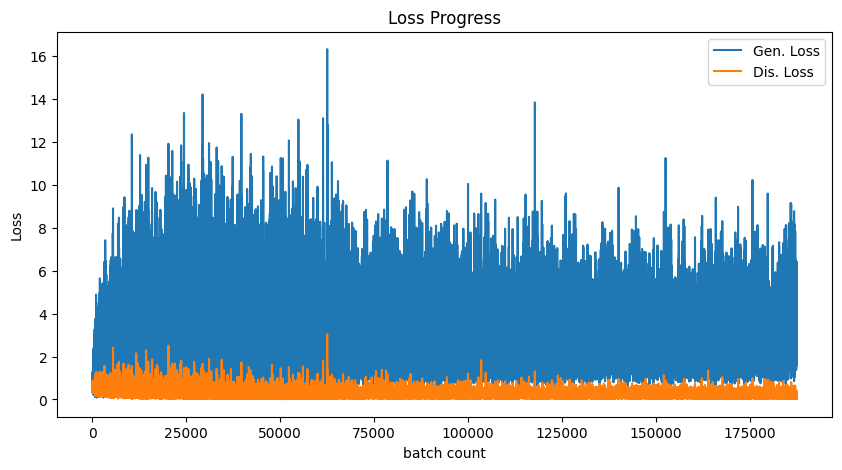

In [19]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_log['gen'], label='Gen. Loss')
plt.plot(loss_log['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
save_path = './models'
os.makedirs(save_path, exist_ok=True)
torch.save(model_dis.state_dict(), save_path+'/discriminator.pt')
torch.save(model_gen.state_dict(), save_path+"/generator.pt")

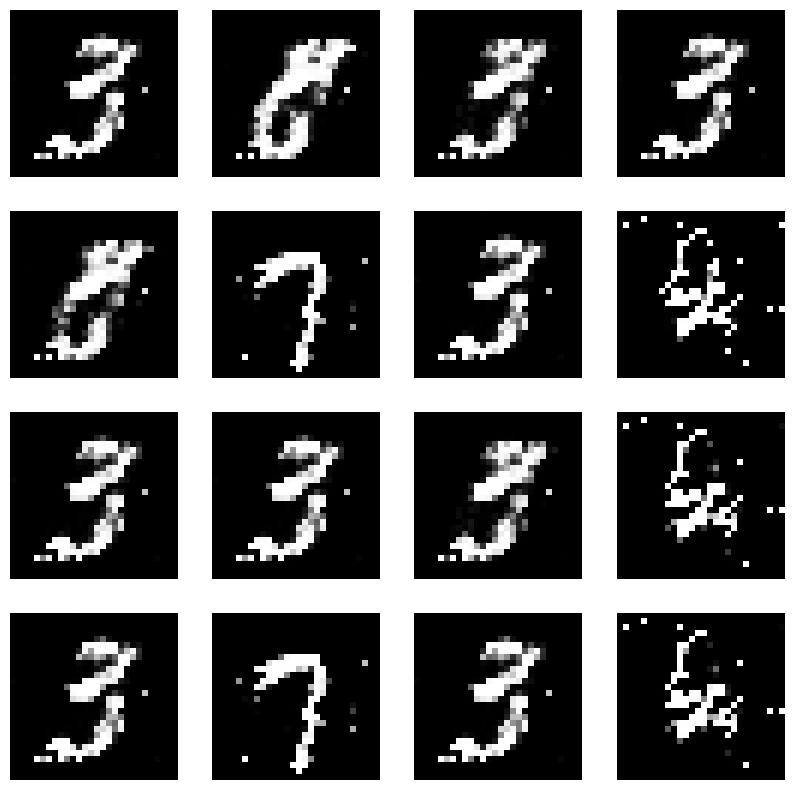

In [21]:
model_gen.eval()

with torch.no_grad():
    new_noise = torch.randn(16, 100, device=device)
    result = model_gen(new_noise).clone().detach().cpu()

plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*result[ii]+0.5),cmap='gray')
    plt.axis('off')

In [13]:
print(device)

cuda
